In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import *
from clvlib.numpy import *

In [2]:
@njit(cache=True)
def lorenz63(t: float, x: np.ndarray, sigma: float = 10.0, beta: float = 8.0 / 3, rho: float = 28.0) -> np.ndarray:
    """
    Computes the time derivatives of the Lorenz '63 system, a classic chaotic system.

    The Lorenz system is defined by the following equations:
        dx/dt = sigma * (y - x)
        dy/dt = x * (rho - z) - y
        dz/dt = x * y - beta * z

    Parameters:
        t (float): Time variable (not used directly in the Lorenz system, but kept for compatibility with solvers).
        x (np.ndarray): State vector of the system [x, y, z].
        sigma (float): Prandtl number, controlling the rate of convection (default: 10.0).
        beta (float): Geometric factor, related to the physical properties of the system (default: 8/3).
        rho (float): Rayleigh number, related to the temperature difference driving the system (default: 28.0).

    Returns:
        np.ndarray: Time derivatives [dx/dt, dy/dt, dz/dt] as a 1D NumPy array.
    """
    # Unpack state variables for clarity
    x1, x2, x3 = x  # x1 -> x, x2 -> y, x3 -> z

    # Lorenz '63 system equations
    dx1_dt = sigma * (x2 - x1)          # dx/dt
    dx2_dt = x1 * (rho - x3) - x2       # dy/dt
    dx3_dt = x1 * x2 - beta * x3        # dz/dt

    # Return the time derivatives as a NumPy array
    return np.array([dx1_dt, dx2_dt, dx3_dt])

In [3]:
@njit(cache=True)
def lorenz63_jacobian(t: float, x: np.ndarray, sigma: float = 10.0, beta: float = 8.0 / 3, rho: float = 28.0) -> np.ndarray:
    """
    Computes the Jacobian matrix of the Lorenz '63 system at a given state.

    The Jacobian represents the linearization of the Lorenz system's dynamics around a specific state (x, y, z):
        dx/dt = sigma * (y - x)
        dy/dt = x * (rho - z) - y
        dz/dt = x * y - beta * z

    Parameters:
        t (float): Time variable (not used directly, kept for compatibility with solvers).
        x (np.ndarray): State vector of the system [x, y, z].
        sigma (float): Prandtl number, controlling the rate of convection (default: 10.0).
        beta (float): Geometric factor, related to the system's physical properties (default: 8/3).
        rho (float): Rayleigh number, related to the temperature difference driving the system (default: 28.0).

    Returns:
        np.ndarray: Jacobian matrix (3x3) evaluated at the current state as a NumPy array.
    """
    # Unpack state variables for clarity
    x1, x2, x3 = x  # x1 -> x, x2 -> y, x3 -> z

    # Define the Jacobian matrix of the Lorenz system
    jacobian = [
        [-sigma,       sigma,    0.0],       # Partial derivatives of dx/dt
        [rho - x3,     -1.0,    -x1],        # Partial derivatives of dy/dt
        [x2,           x1,      -beta]       # Partial derivatives of dz/dt
    ]

    # Convert to a NumPy array for convenient numerical use
    return np.array(jacobian)

In [4]:
N = 10000
t0 = 0.
tf = 100.
time = np.linspace(t0,tf,N)
u0 = np.array([1.0, 0.0, 0.0])

sigma = 10.0
beta = 8.0 / 3
rho = 28.0

In [5]:
# Generate the trajectory of the Lorenz system using the time grid from cell index 3.
def lorenz63_wrapper(x, t, sigma, beta, rho):
	return lorenz63(t, x, sigma, beta, rho)

x = scipy.integrate.odeint(lorenz63_wrapper, u0, time, args=(sigma, beta, rho)).T

In [6]:
np.shape(x)

(3, 10000)

In [7]:
Q, R, LE, LE_history, CLVs = lyap_analysis(lorenz63, lorenz63_jacobian, x, time, sigma, beta, rho, k_step=7)

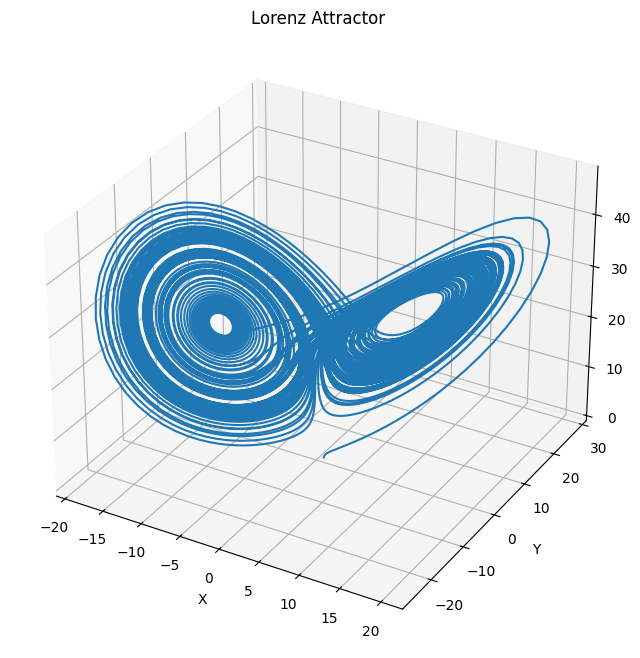

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[0, :], x[1, :], x[2, :])
ax.set_title("Lorenz Attractor")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [9]:
np.shape(LE_history)

(3, 1429)

ValueError: x and y must have same first dimension, but have shapes (10000,) and (1429,)

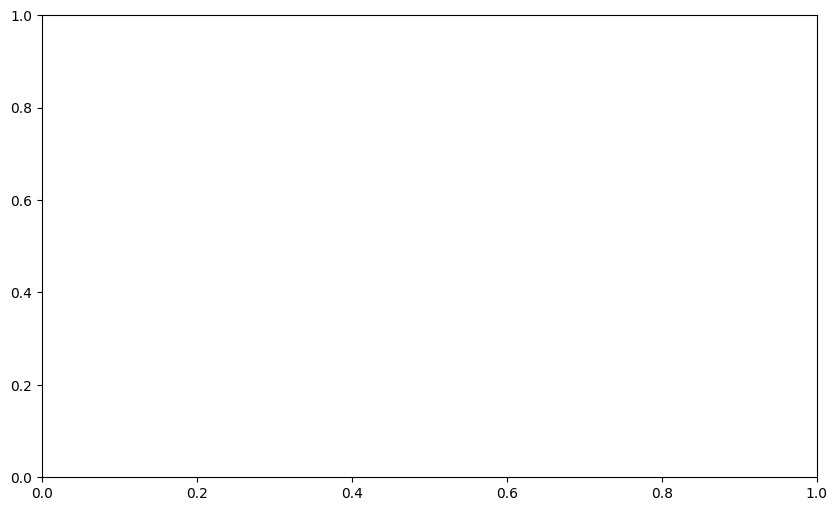

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(time, LE_history[0, :], label='LE 1')
plt.plot(time, LE_history[1, :], label='LE 2')
plt.plot(time, LE_history[2, :], label='LE 3')
plt.xlabel('Time')
plt.ylabel('Lyapunov Exponent')
plt.title('LE History vs Time')
plt.legend()
plt.show()

In [11]:
print("Final Lyapunov Exponents:", LE)

Final Lyapunov Exponents: [  0.71939161   0.03046156 -14.41642288]


In [12]:
ICLE = compute_ICLE(lorenz63_jacobian, x, time, CLVs, sigma, beta, rho, k_step=7)

In [13]:
mean_ICLE = np.mean(ICLE, axis=1)
print("Time mean of the ICLEs:", mean_ICLE)

Time mean of the ICLEs: [  0.7112754   -0.54681234 -14.88781692]


In [14]:
V1 = CLVs[:,1:,:]
V2 = CLVs[:,:1,:]

In [15]:
theta = principal_angles(V1, V2)

In [16]:
np.shape(theta)

(1, 1429)